### Raster Data to Explore
    Landscan
    Worldpop
    NTL - DMSP & VIIRS
    Africapolic 
    EU Human Settlement Layer
    MODIS built layer
    Facebook Human Settlement
    GRUMP
    
### Define Urban Density
    Go w/ former US Census threshold of >= 1000 ppl per sq mile
    https://www2.census.gov/geo/pdfs/reference/GARM/Ch12GARM.pdf

In [1]:
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from rasterio.mask import mask
import geopandas as gpd
import fiona
import rasterio
import rasterio.mask
import numpy as np
import skimage.io as skio

In [78]:
cwd = os.getcwd()
cwd

'/tana-crunch/cascade/projects/NightTimeLights/notebooks/jupyter'

In [2]:
# will build out folders later

# data folder git will ignore
infilepath = "/home/cascade/tana-crunch-cascade/projects/NightTimeLights/data/raw/" 

# data folder git will not ignore - NO BIG FILES 
outfilePath = "/home/cascade/tana-crunch-cascade/projects/NightTimeLights/temp_data/"



# Step 1 - Input file

    Becomes a rasterio object, check meta data 
    Bands are numpy arrays

In [8]:
africa1k_2000 = rasterio.open(infilepath+"AFR_PPP_2020_adj_v2.tif") # <------ changed to 2020
africa1k_2000.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11161,
 'nodata': -3.4028234663852886e+38,
 'transform': Affine(0.00833333329999305, 0.0, -33.3254172868223,
       0.0, -0.00833333329999305, 41.791250202105076),
 'width': 12575}

In [81]:
band1 = africa1k_2000.read(1)

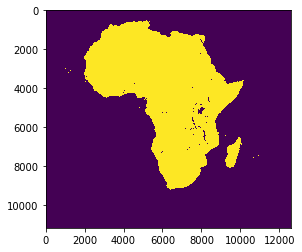

In [82]:
plot.show(band1)

In [83]:
len(np.unique(band1))

2765743

# Step 2 - Make a mask

    Becomes a rasterio object, check meta data 
    Bands are numpy arrays

In [9]:
# https://www2.census.gov/geo/pdfs/reference/ua/Defining_Rural.pdf

density = 1000/ 2.59 #density per sq km from sq mi
print(density)

386.1003861003861


### Dilate and Erode 
With 3x3 kernal ... must be odd number to stay centered 

[0. 1.]


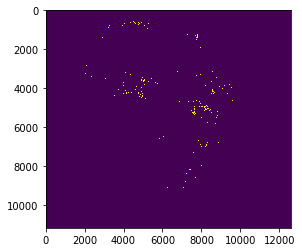

In [10]:
# Let's try to make the mask directy with rasterio

new_mask = africa1k_2000.read(1)
new_mask[new_mask < 386.10] = 0
new_mask[new_mask > 386.10] = 1
print(np.unique(new_mask)) # ensure that it's zeros and ones
plot.show(new_mask) # Sanity check 


In [11]:
# With 3x3 kernal ... must be odd number to stay centered  
# try dilate, erode, open and close

import cv2

kernal = np.ones((3,3), np.uint8)
mask_dilated_close = cv2.morphologyEx(new_mask, cv2.MORPH_CLOSE, kernal)
mask_dilated_open = cv2.morphologyEx(new_mask, cv2.MORPH_OPEN, kernal)
mask_erode = cv2.erode(new_mask, kernal, iterations = 1)
mask_dilate = cv2.dilate(new_mask, kernal, iterations = 1)

# write them out and check in QGIS
# ----------------> Need to do this without writing files <-----
kwargs = africa1k_2000.meta

# Update kwargs (change in data type)
kwargs.update(dtype=rasterio.float32, count = 1)

# Let's see what is in there
print(kwargs)

# erode check
# with rasterio.open(infilepath+'africa1k_2020_maskErode.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, mask_erode.astype(rasterio.float32))

# dilate check 
# with rasterio.open(infilepath+'africa1k_2020_maskDilate.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, mask_dilate.astype(rasterio.float32)) 
        
# close raster check
with rasterio.open(infilepath+'africa1k_2020_maskClose.tif', 'w', **kwargs) as dst:
        dst.write_band(1, mask_dilated_close.astype(rasterio.float32))

# open raster check        
# with rasterio.open(infilepath+'africa1k_2020_maskOpen.tif', 'w', **kwargs) as dst:
#         dst.write_band(1, mask_dilated_open.astype(rasterio.float32))

#plot.show(mask_dilated)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 12575, 'height': 11161, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.00833333329999305, 0.0, -33.3254172868223,
       0.0, -0.00833333329999305, 41.791250202105076)}


#### Notes
- Dilate alone connects too many cites
- Erode alone may make too few cities
- Open greatly reduces the number of polygons but may be best for a conservitive estimate
- Close connects them and may make it difficult to attach the correct label with correct political boundaries

In [92]:
# Sanity check on number of polygons 
# from skimage import measure
# label_test = measure.label(mask_dilated, background=0, return_num=True)
# label_test_arr = label_test[0]
# label_test_num = label_test[1] # 96 polygons
# label_test_num

# Step 3 - ShapeFiles

In [ ]:
# open dialated mask and make some polygons
from rasterio import features as features

with rasterio.open(infilepath+'africa1k_2000_maskClose.tif') as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.read(1)

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

### check time
checkpoint = time.time()
#run some lines
print("elapsed time is: {}s".format(time.time()-checkpoint))

Don't need to write outfile as shapes ... can do is-inside script without making shape

In [98]:
# Sanity check
print(len(geom['coordinates']))
print(geom.keys())

28680
dict_keys(['type', 'coordinates'])


In [99]:
import pandas as pd
import shapely.geometry.polygon as Polygon

# turn dict into normal data frame
close_pd = pd.DataFrame.from_dict(geom)['coordinates'].apply(Polygon)


TypeError: 'module' object is not callable

In [96]:
close_pd.head

<bound method NDFrame.head of 0        [[-33.325417, 41.79125], [-33.325417, -51.2170...
1        [[20.024582, -34.525416], [20.041249, -34.5254...
2        [[9.824583, 37.332917], [9.824583, 37.324584],...
3        [[19.024583, -34.333749], [19.032916, -34.3337...
4        [[19.882916, -34.467083], [19.882916, -34.4754...
5        [[18.457916, -34.300416], [18.457916, -34.3254...
6        [[19.149583, -34.408749], [19.149583, -34.4170...
7        [[23.316249, -34.042083], [23.374582, -34.0420...
8        [[10.041249, 37.257917], [10.041249, 37.232917...
9        [[25.374582, -34.017083], [25.382916, -34.0170...
10       [[22.991249, -34.042083], [22.991249, -34.0504...
11       [[20.449582, -34.025416], [20.449582, -34.0420...
12       [[19.124583, -34.358749], [19.141249, -34.3587...
13       [[23.016249, -34.017083], [23.016249, -34.0254...
14       [[18.474583, -34.350416], [18.482916, -34.3504...
15       [[25.357916, -34.000416], [25.357916, -34.0087...
16       [[10.074583, 37.2

In [ ]:
# move into a geo pandas data frame and assign it some geometry

dilate_pdf = gp.GeoDataFrame(dilate_pd, geometry = 'geometry')
dilate_pdf.head(6)

In [ ]:
# isolate just the geometry Polygon column 

newer_pdf = gp.GeoDataFrame(new_pdf['geometry'])
newer_pdf.head(6)

### The cell below this works ... makes a shapefile 

In [ ]:
# Explort it as a shape file
# careful with the file path ... this is going to my notebooks folder right now
newer_pdf.to_file('worldpop_2000_test.shp', driver='ESRI Shapefile')

In [ ]:
# Let's see if I can find zonal stats

In [ ]:
# https://automating-gis-processes.github.io/CSC18/lessons/L6/zonal-statistics.html

from rasterstats import zonal_stats

### Work around for problem

In [ ]:
# Sanity check on number of polygons 
from skimage import measure
label_test = measure.label(new_mask, background=0, 
                           connectivity = 2, # diagonal connect
                           #neighbors = 8,
                           return_num=True)
label_test_arr = label_test[0]
label_test_num = label_test[1] # 96 polygons

# no connectivity change 38377

In [ ]:
### write out the ski image

with rasterio.open(infilepath+'africa1k_2000_mask_skimage.tif', 'w', **kwargs) as dst:
        dst.write_band(1, label_test_arr.astype(rasterio.float32))


In [ ]:
# Need to figure out how to turn geo pandas back into a geojson dict
with fiona.open("worldpop_2000_test.shp", "r") as shapefile:                                #<--- Need to figure out how to get the geometry from shp file directly 
    features = [feature["geometry"] for feature in shapefile]

with rasterio.open(filepath+"AFR_PPP_2000_adj_v2.tif") as src:                        #<--- Need to figure out how to get it not to write to a file, but just store in memory at this point
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(filepath+"AFR_PPP_2000_adj_MASK.tif", "w", **out_meta) as dest:
    dest.write(out_image) 


In [ ]:
mask_test_2000 = rasterio.open(filepath+'AFR_PPP_2000_adj_MASK.tif')
plot.show(mask_test_2000)

In [ ]:
np.unique(mask_test_2000.read(1))

In [ ]:
# from shapely.geometry import shape

# test = shape(geom)
# type(test)

In [ ]:
# get it into a geopandas DF for explore
import geopandas as gp
geom_gdf = gp.GeoDataFrame.from_records(geom)
type(geom_gdf)

In [ ]:
# check it 
geom_gdf.head(2)

In [ ]:
geom_gdf[type=='Polygon'] = 'POLYGON '
geom_gdf.head(2)

In [ ]:
geom_gdf['geometry']=geom_gdf['False'].astype(str)+geom_gdf['coordinates'].astype(str)

In [ ]:
geom_gdf.head(6)

In [ ]:
test = gp.GeoDataFrame(geom_gdf['geometry'])
test.head(6)

In [ ]:
# try to write it as a shape file
test.to_file('worldpop_2000_test.shp', driver='ESRI Shapefile')

In [ ]:
type(dst)

In [ ]:
dir(africa1k_2000_poly)

In [ ]:
test = rasterio.features.dataset_features(africa1k_2000_poly)







In [ ]:
type(test)

In [ ]:
# ask Kelly about what to do with the nodata values messing everything up 
ghana100m_2010 = rasterio.open(filepath+"GHA10_040213.tif")
ghana100m_2010.meta

In [ ]:
plot.show(ghana100m_2010)

In [ ]:
ghana100m_2010_arr = ghana100m_2010.read_band(1)

In [ ]:
# check data range
np.unique(ghana100m_2010_arr)

In [ ]:
# Zoom into a subset
#window = rasterio.windows.Window(1024, 1024, 1280, 2560)

subset = ghana100m_2010.read(1, window=((7000, 7200), (2700, 3300)))

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
#plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
type(subset)

In [ ]:
plt.hist(subset, range = [0,100])
plt.show()

In [ ]:
import copy

subset_copy = copy.copy(subset)
subset_copy[subset<1] = 0

In [ ]:
plt.figure(figsize=(6,8.5))
plt.imshow(subset_copy)
plt.colorbar(shrink=0.5)
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
plt.hist(subset_copy)
plt.show()

In [ ]:
test = rasterio.open(filepath+"GHA10_040213.tif")

In [ ]:
test.mask

In [ ]:
type(test_band)

In [ ]:
from rasterio.features import shapes
mask = None
with rasterio.drivers():
    with rasterio.open(filepath+"GHA10_040213.tif", window = ((7000, 7200), (2700, 3300))) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.affine)))

In [ ]:
geoms = list(results)

In [ ]:
print(geoms[4])

In [ ]:
import geopandas as gp
gpd_polygonized_raster  = gp.GeoDataFrame.from_features(geoms)

In [ ]:
gpd_polygonized_raster